## Neural Network

In [68]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
import pprint as pp
import random
import time
import sys
import os
try:
   import cPickle as cPickle
except:
   import pickle as cPickle

### Load Data

In [69]:
data = pd.read_csv('dataset/processed_pos_neg_reviews.csv', encoding='latin-1')

In [70]:
data.Label.value_counts()

NEGATIVE    82037
POSITIVE    82037
Name: Label, dtype: int64

In [71]:
data.head()

,ProductId,Rating,Summary,Text,Label
0,B001NXHY8Y,5,Daughter Approved,I was very upset when I was unable to find an ...,POSITIVE
1,B00813GRG4,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,NEGATIVE
2,B001BS4G6O,4,Pretty good but you can do better,Pill pockets usually work well though sometime...,POSITIVE
3,B000UA0QIQ,2,Cough Medicine,If you are looking for the secret ingredient i...,NEGATIVE
4,B005HG9ET0,5,Great taste and refreshing,I'm an avid drinker of Smart Water because of ...,POSITIVE


### Data Preparation

Training data

In [72]:
# first 100000 reviews
training_data = data[0:70000].reset_index(drop=True)
training_data_length = training_data.shape[0]
training_data.head()

,ProductId,Rating,Summary,Text,Label
0,B001NXHY8Y,5,Daughter Approved,I was very upset when I was unable to find an ...,POSITIVE
1,B00813GRG4,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,NEGATIVE
2,B001BS4G6O,4,Pretty good but you can do better,Pill pockets usually work well though sometime...,POSITIVE
3,B000UA0QIQ,2,Cough Medicine,If you are looking for the secret ingredient i...,NEGATIVE
4,B005HG9ET0,5,Great taste and refreshing,I'm an avid drinker of Smart Water because of ...,POSITIVE


Validation data

In [73]:
# middle 6019 reviews
validation_data = data[70000:76019].reset_index(drop=True)
validation_data_length = validation_data.shape[0]
validation_data.head()

,ProductId,Rating,Summary,Text,Label
0,B000EY1NXK,5,Great taste in a larger size,I purchased the six 10oz bottles of this musta...,POSITIVE
1,B001VJ0B0I,2,"Gross by-products, sugar, and food colorings--...",I completely agree that the ingredients for th...,NEGATIVE
2,B001HXJG8G,3,Sugar coated,These chopped dates appear to be coated with a...,POSITIVE
3,B001VJ0B0I,2,Read the Ingredient List,Make sure you read the list of ingredients bef...,NEGATIVE
4,B000F8GWRM,5,twizzlers sugarfree licorice,not many tasty sugar free products and this is...,POSITIVE


Testing data

In [74]:
# last 6018 reviews
test_data = data[76019:82037].reset_index(drop=True)
test_data_length = test_data.shape[0]
test_data.head()

,ProductId,Rating,Summary,Text,Label
0,B003NV2IG2,2,Inconsistent Taste,I first tasted Annie Chun's seaweed three year...,NEGATIVE
1,B003056CWM,3,Juicy Vegan Franks!,These deli franks are one of the greatest vega...,POSITIVE
2,B003NV2IG2,2,"Nothing like sushi, that's for sure","For me, these were a total bust. The texture s...",NEGATIVE
3,B000HBO134,5,Simply marvelous!!!!,I could never find the Peach flavored version ...,POSITIVE
4,B003NV2IG2,2,Mediocre for Seaweed Snacking,This is one of many varieties of seaweed snack...,NEGATIVE


#### What is the shape of our input data

Training data

In [75]:
pp.pprint(training_data.shape)

(70000, 5)


In [76]:
pp.pprint(training_data.Label.shape)

(70000,)


There are 5 features and 70000 samples in our training set

Validation data

In [77]:
pp.pprint(validation_data.shape)

(6019, 5)


In [78]:
pp.pprint(validation_data.Label.shape)

(6019,)


Test data

In [79]:
pp.pprint(test_data.shape)

(6018, 5)


In [80]:
pp.pprint(test_data.Label.shape)

(6018,)


### Transform Text into Numbers Using the Bag-of-Words Technique

Neural Networks only understand numbers hence we have to find a way to represent our text inputs in a way it can understand

In [81]:
vocab = set(total_counts.keys())
vocab_size = len(vocab)
print(vocab_size)

183506


We can see that from our `training_data`, we have a total of **183041** unique words. Use this to build up our vocabulary vector containing columns of all these words.

Because, **183041**, can be a large size in memory (a matrix of size **183041 by 100000**), lets allocate its memory once with default zeros and will only change its contents accordingly later.

In [82]:
vocab_vector_column = np.zeros((1, vocab_size))
pp.pprint(vocab_vector_column.shape)
pp.pprint(vocab_vector_column)

(1, 183506)
array([[ 0.,  0.,  0., ...,  0.,  0.,  0.]])


Now, let's create a dictionary that allows us to look at every word in our vocabulary and map it to the `vocab_vector` column.

In [83]:
#  Maps a word to its column in the vocab_vector
word_column_dict = {}

for i, word in enumerate(vocab):
    # {key: value} is {word: column}
    word_column_dict[word] = i

In [84]:
def slice_dict(dict, pattern):
    return {k:v for k,v in dict.items() if k.startswith(pattern)}

In [85]:
pp.pprint(slice_dict(word_column_dict, "."))

{'.': 8802,
 '."': 107006,
 '.(with': 58995,
 '.-_-': 104097,
 '..': 128309,
 '..!': 131585,
 '...': 170534,
 '..."Made': 100154,
 '..."regular': 10942,
 "...'": 146846,
 '...(6);...': 71409,
 '...(7)}.<br': 110677,
 '...(any': 13203,
 '...)': 20826,
 '...).': 75509,
 '...):<br': 46670,
 '...)<br': 77713,
 '...*]<br': 110549,
 '...,<br': 96142,
 '....': 45593,
 '....!Taste': 154712,
 '...."': 182950,
 '.....': 7403,
 '....."Fog': 108012,
 '.....(4),<br': 131439,
 '......': 436,
 '.......': 59306,
 '......."blood': 114675,
 '........': 54361,
 '.........': 149878,
 '..........': 158081,
 '...........': 30956,
 '............': 171873,
 '.............': 159017,
 '..............': 38008,
 '.............................': 110194,
 '................................': 58533,
 '...................................': 161139,
 '....................................': 116112,
 '.......................................': 28430,
 '.........................................': 121029,
 '.................

We are going to use the count of words as the input to our neural network. The `vocab_vector` will have columns for all the words in our training data in the form of `{key: value}` i.e `{word: count}` as held by the `word_column_dict`  python `Dictionary`. The individual word counts in any particular review is updated from 0 to a number based on a word's total count in any single text.

This means that the words with a higher count might have a higher weight in determining whether a text is a spam or not.

In [86]:
def update_input_layer(text):
    pp.pprint(text)
    global vocab_vector_column
    
    # clear out previous state, reset the vector to be all 0s
    vocab_vector_column *= 0
    for word in text.split(" "):
        vocab_vector_column[0][word_column_dict[word]] += 1

In [87]:
def get_target_for_label(label, is_num=True):
    if(is_num):
        if(label == 'POSITIVE'):
            return 1
        else:
            return 0
    return label

In [88]:
random_review = random.randrange(0,training_data.shape[0], 50)

In [89]:
update_input_layer(training_data.Text[random_review])

('Hands down my favorite sauce, especially for Mexican food, eggs and stews. '
 'It has become a staple in our kitchen.')


In [90]:
get_target_for_label(training_data.Label[random_review])

1

In [91]:
get_target_for_label(training_data.Label[random_review], is_num=False)

'POSITIVE'

In [92]:
vocab_vector_column

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.]])

### Build the SentimentalNeuralNetwork

In [148]:
# Let's tweak our network from before to model these phenomena
class SentimentalNeuralNetwork(object):
    def __init__(self, training_data, num_hidden_nodes = 10, num_epochs = 10, learning_rate = 0.1):
        # set our random number generator 
        np.random.seed(1)
        # pre-process data
        self.pre_process_data(training_data)
        
        # set network paramaters
        self.num_features = len(self.vocab)
        self.vocab_vector = np.zeros((1, len(self.vocab)))
        self.num_input_nodes = self.num_features
        self.num_hidden_nodes = num_hidden_nodes
        self.num_epochs = num_epochs
        self.num_output_nodes = 1
        self.learning_rate = learning_rate
        
        # for printing later
        self.losses = {'train':[], 'validation':[]}

        # initialize weights
        self.weights_i_h = np.random.randn(self.num_input_nodes, self.num_hidden_nodes)
        self.weights_h_o = np.random.randn(self.num_hidden_nodes, self.num_output_nodes)
        
    def forward_backward_propagate(self, text, label):
        ### Forward pass ###
        # Input Layer
        self.update_input_layer(text)
        # Hidden layer
        hidden_layer = self.vocab_vector.dot(self.weights_i_h)
        # Output layer
        output_layer = self.sigmoid(hidden_layer.dot(self.weights_h_o))
        
        ### Backward pass ###
        # Output error
        output_layer_error = output_layer - self.get_target_for_label(label)
        output_layer_delta = output_layer_error * self.sigmoid_derivative(output_layer)

        # Backpropagated error - to the hidden layer
        hidden_layer_error = output_layer_delta.dot(self.weights_h_o.T)
        # hidden layer gradients - no nonlinearity so it's the same as the error
        hidden_layer_delta = output_layer_error 

        # update the weights - with grdient descent
        self.weights_h_o -= hidden_layer.T.dot(output_layer_delta) * self.learning_rate 
        self.weights_i_h -= self.vocab_vector.T.dot(hidden_layer_delta) * self.learning_rate 
        
        if(output_layer >= 0.5 and self.get_target_for_label(label) == 1):
                self.correct_so_far += 1
        elif(output_layer < 0.5 and self.get_target_for_label(label) == 0):
                self.correct_so_far += 1
        
    def train(self):
        # iterate through all epochs
        for epoch in range(self.num_epochs):
            self.correct_so_far = 0
            start = time.time()
            training_loss = 0

            for row in range(len(training_data)):
                # Forward and Back Propagation
                self.forward_backward_propagate(training_data.Text[row], training_data.Label[row])

                # calculate our speed
                elasped_time = float(time.time() - start + 0.001)
                samples_per_second = row / float(elasped_time)
                # calculate our accuracy
                training_accuracy = self.correct_so_far * 100 / float(row+1)
                # print progress of training
                sys.stdout.write("\rEpoch: "+ str(epoch)
                                 + " Progress: " + str(100 * row/float(training_data.shape[0]))[:4] + "%"
                                 + " Speed(samples/sec): " + str(samples_per_second)[0:5] 
                                 + " #Correct: " + str(self.correct_so_far) 
                                 + " #Trained: " + str(row+1) 
                                 + " Training Accuracy: " + str(training_accuracy)[:4] + "%")
                
            training_loss = self.run(training_data[0:7000])
            self.losses["train"].append(training_loss)   
            print("") 
            
            
    def test(self, test_data):
        # How many predictions are correct out of total training
        correct = 0
        # start time of one epoch
        start = time.time()
        # iterate through all training samples
        for i in range(0, test_data.shape[0]):
            # get prediction
            pred = self.predict(test_data.Text[i])
            # count how many we validate as correct
            if(pred >= 0.5 and self.get_target_for_label(test_data.Label[i]) == 1):
                correct += 1
            elif(pred < 0.5 and self.get_target_for_label(test_data.Label[i]) == 0):
                correct += 1
            # calculate our sampling rate
            reviews_per_second = i / float(time.time() - start + 0.001)
            # print out the validation metrics
            sys.stdout.write("\rProgress:" + str(100 * i/float(test_data.shape[0]))[:4] + "%"
                             + " Speed(reviews/sec):" + str(reviews_per_second)[0:5] 
                             + " #Correct:" + str(correct) 
                             + " #Tested:" + str(i+1) 
                             + " Testing Accuracy:" + str(correct * 100 / float(i+1))[:4] + "%")
 
            print("")
    
    def run(self, input_data):
        # total losses for sample
        loss = 0
        # iterate through all training samples
        for i in range(0, input_data.shape[0]):
            # get prediction
            pred = self.predict(input_data.Text[i])
            # calculate the loss
            loss += np.mean(np.square((pred - self.get_target_for_label(input_data.Label[i]))))
        return loss/float(input_data.shape[0]) 

            
    def predict(self, text):
        ### Forward pass ###
        # Input Layer
        self.update_input_layer(text)
        # Hidden layer
        self.hidden_layer = self.vocab_vector.dot(self.weights_i_h)
        # output layer
        output_layer = self.sigmoid(self.hidden_layer.dot(self.weights_h_o))
        
        return output_layer.flatten()
        
    def visualise_training(self):
        plt.plot(self.losses['train'], label='Training loss')
        plt.legend()
                             
    def pre_process_data(self, training_data):
        vocab = set()
        
        for review in training_data.Text:
            for word in review.split(" "):
                vocab.add(word)
                
        self.vocab = list(vocab)
        
        self.word_to_column = {}
        for i, word in enumerate(self.vocab):
            self.word_to_column[word] = i
            
    def update_input_layer(self, text):
        # clear out previous state, reset the vector to be all 0s
        self.vocab_vector *= 0
        for word in text.split(" "):
            if(word in self.word_to_column.keys()):
                self.vocab_vector[0][self.word_to_column[word]] = 1
            
    def get_target_for_label(self, label):
        if(label == 'POSITIVE'):
            return 1
        elif(label == 'NEGATIVE'):
            return 0
    
    def sigmoid(self,x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self,x):
        return x * (1 - x)   

In [165]:
nn = SentimentalNeuralNetwork(training_data, num_hidden_nodes=10, num_epochs=2, learning_rate=0.001)

Make sure you check for any biasness before training. We should have a **50-50** chance for both `POSITIVE` and `NEGATIVE` reviews. This is because the network hasn't even trained yet and what it is outputing is basically guesswork.

**NB** In general starting from a non-biased point like this is very desirable.

In [151]:
nn.test(test_data)

Progress:99.9% Speed(reviews/sec):768.2 #Correct:2898 #Tested:6018 Testing Accuracy:48.1%

In [152]:
nn.train()

Epoch: 0 Progress: 99.9% Speed(samples/sec): 156.4 #Correct: 51470 #Trained: 70000 Training Accuracy: 73.5%
Epoch: 1 Progress: 99.9% Speed(samples/sec): 160.4 #Correct: 56975 #Trained: 70000 Training Accuracy: 81.3%


Network has already been trained, and obviously we now don't expect a **50-50** performance but something much better if indeed the newtork has learned.

In [158]:
nn.test(test_data)

Progress:99.9% Speed(reviews/sec):772.6 #Correct:4814 #Tested:6018 Testing Accuracy:79.9%

 A graph of training loss against the no. of epochs. 

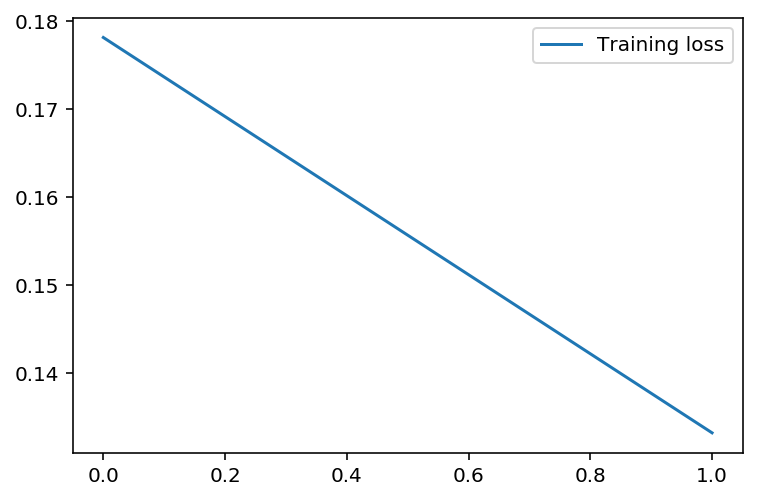

In [159]:
nn.visualise_training()

In [163]:
nn.predict("This product sucks!! I bought it and it proved disgusting. Do not buy this rip-off.")

array([ 0.28308101])

In [164]:
nn.predict("Wondeful and very awesome quality product")

array([ 0.76804277])